In [1]:
import random
import time

# ----- Problem Setup -----
courses = ["C1", "C2", "C3", "C4", "C5"]
teachers = ["T1", "T2", "T3"]
groups = ["G1", "G2", "G3"]
rooms = ["R1", "R2"]
slots = ["S1", "S2", "S3", "S4", "S5"]

course_teacher = {"C1": "T1", "C2": "T2", "C3": "T3", "C4": "T1", "C5": "T2"}
course_group = {"C1": "G1", "C2": "G1", "C3": "G2", "C4": "G3", "C5": "G2"}

domain = {}
for c in courses:
    domain[c] = [(s, r) for s in slots for r in rooms]

# ----- Constraint Checking -----
def is_consistent(course, value, assignment):
    slot, room = value
    teacher = course_teacher[course]
    group = course_group[course]

    for c, (s, r) in assignment.items():
        if s == slot:
            if course_teacher[c] == teacher:  # teacher clash
                return False
            if course_group[c] == group:      # student clash
                return False
            if r == room:                     # room clash
                return False
    return True

# ----- Heuristics -----
def select_unassigned_variable(assignment, domain):
    unassigned = [v for v in domain.keys() if v not in assignment]
    # MRV: Minimum Remaining Values
    return min(unassigned, key=lambda var: len(domain[var]))

def order_values(var, domain, assignment):
    # LCV: Least Constraining Value
    def constraint_count(value):
        count = 0
        for other_var in domain:
            if other_var not in assignment and value in domain[other_var]:
                count += 1
        return count
    return sorted(domain[var], key=constraint_count)

# ----- Backtracking with Heuristics -----
def backtrack(assignment, domain):
    if len(assignment) == len(domain):
        return assignment
    var = select_unassigned_variable(assignment, domain)
    for value in order_values(var, domain, assignment):
        if is_consistent(var, value, assignment):
            assignment[var] = value
            result = backtrack(assignment, domain)
            if result:
                return result
            del assignment[var]
    return None

# ----- Forward Checking -----
def forward_checking(assignment, domain):
    if len(assignment) == len(domain):
        return assignment
    var = select_unassigned_variable(assignment, domain)
    for value in order_values(var, domain, assignment):
        if is_consistent(var, value, assignment):
            assignment[var] = value
            new_domain = {v: list(vals) for v, vals in domain.items()}
            slot, room = value
            teacher = course_teacher[var]
            group = course_group[var]
            # Prune conflicting values
            for other in domain:
                if other not in assignment:
                    new_domain[other] = [val for val in new_domain[other]
                        if not ((val[0] == slot) and
                                (course_teacher[other] == teacher or
                                 course_group[other] == group or
                                 val[1] == room))]
            result = forward_checking(assignment, new_domain)
            if result:
                return result
            del assignment[var]
    return None

# ----- Performance Comparison -----
runs = 5
results = {"Backtracking": [], "Forward Checking": []}

for _ in range(runs):
    t1 = time.time()
    backtrack({}, domain)
    results["Backtracking"].append(time.time() - t1)

    t2 = time.time()
    forward_checking({}, domain)
    results["Forward Checking"].append(time.time() - t2)

print("Average Time (s):")
print("Backtracking:", sum(results["Backtracking"]) / runs)
print("Forward Checking:", sum(results["Forward Checking"]) / runs)


Average Time (s):
Backtracking: 7.028579711914063e-05
Forward Checking: 6.656646728515625e-05


DEMONSTRATING TIMETABLE GENERATION
Courses: ['CS101', 'CS102', 'CS201', 'CS202', 'MATH101', 'MATH102', 'PHY101', 'PHY102', 'CHEM101', 'BIO101']
Rooms: ['R100', 'R101', 'R102', 'R103', 'R104']
Time slots: ['Mon_9', 'Mon_10', 'Mon_11', 'Mon_14', 'Mon_15', 'Tue_9', 'Tue_10', 'Tue_11', 'Tue_14', 'Tue_15', 'Wed_9', 'Wed_10', 'Wed_11', 'Wed_14', 'Wed_15']
Professors: {'CS101': 'Prof_A', 'CS102': 'Prof_A', 'CS201': 'Prof_B', 'CS202': 'Prof_B', 'MATH101': 'Prof_C', 'MATH102': 'Prof_C', 'PHY101': 'Prof_D', 'PHY102': 'Prof_D', 'CHEM101': 'Prof_E', 'BIO101': 'Prof_F'}
Constraints: {'professor_conflicts': True, 'room_availability': [('R100', 3), ('R101', 2), ('R102', 2), ('R103', 1), ('R104', 1)], 'course_prerequisites': [('CS101', 'CS102'), ('MATH101', 'MATH102'), ('PHY101', 'PHY102')]}

Solving with Forward Checking and Heuristics...
Solution found in 0.1026 seconds!
Nodes explored: 11
Backtracks: 0

GENERATED TIMETABLE

Time Slot    Course     Room     Professor   
-----------------------------

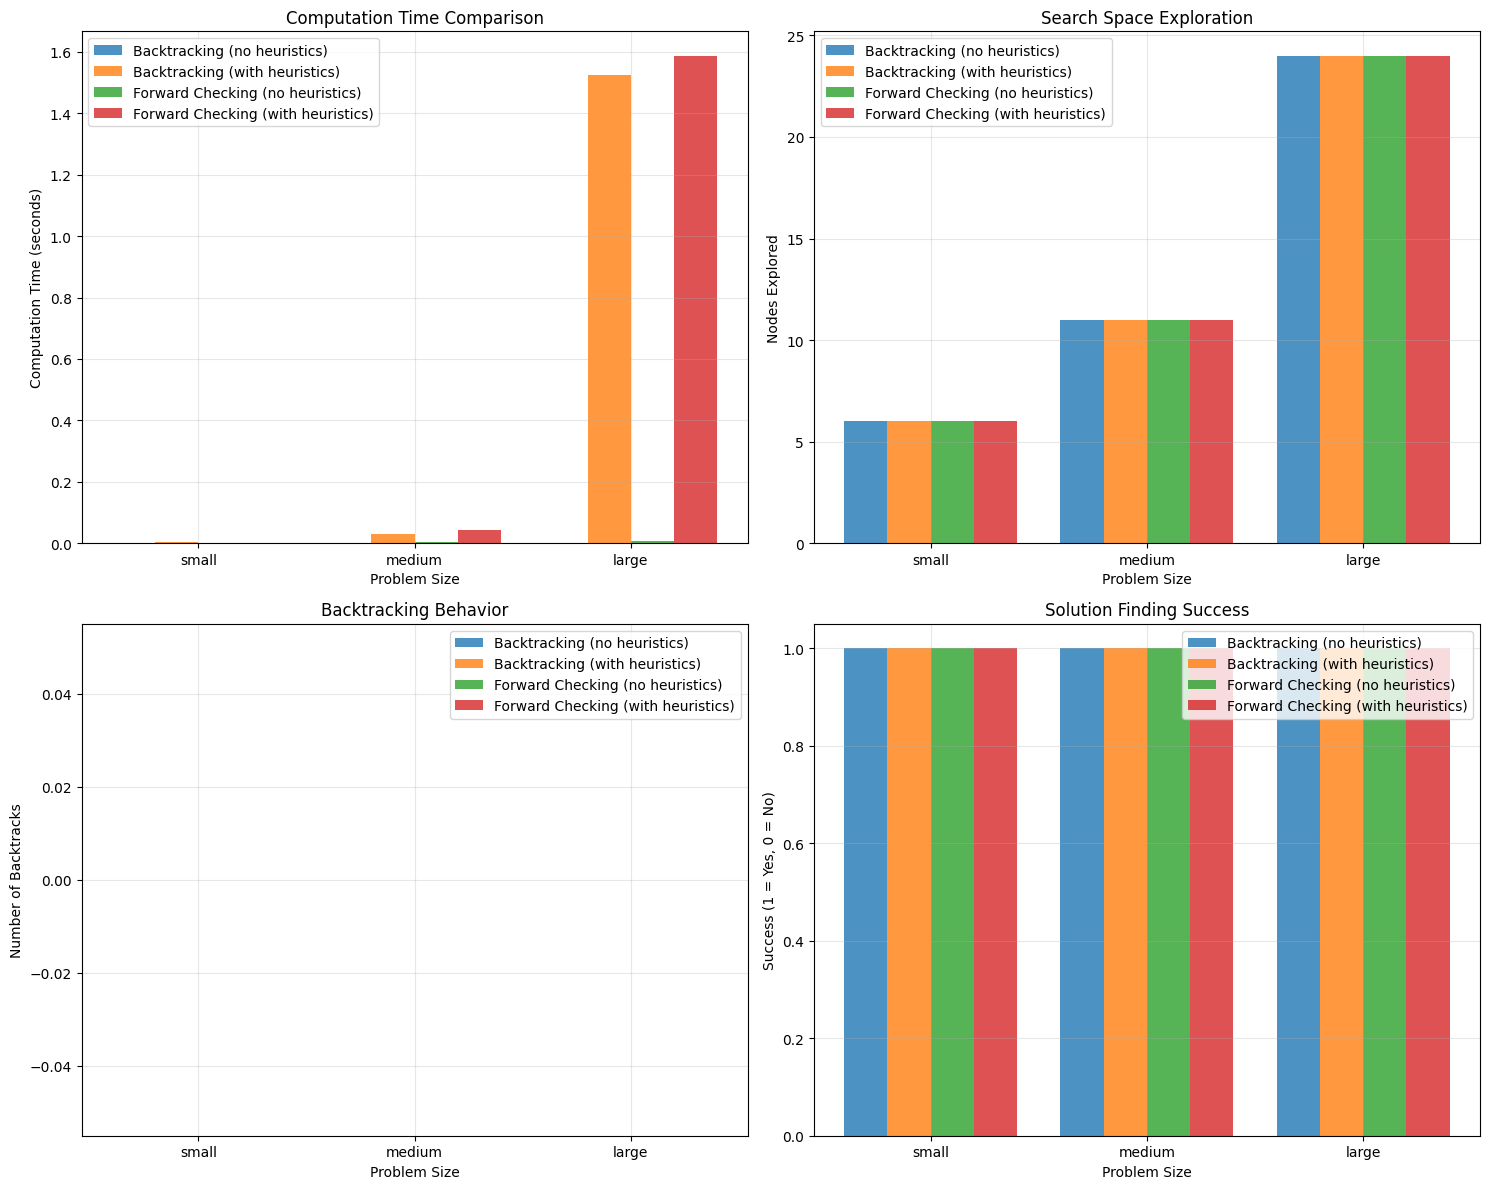

In [2]:
import random
import time
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Set, Tuple, Optional

class TimetableCSP:
    def __init__(self, courses, rooms, time_slots, professors, constraints):
        self.courses = courses  # List of course codes
        self.rooms = rooms      # List of room names
        self.time_slots = time_slots  # List of time slots (e.g., ['Mon_9', 'Mon_10', ...])
        self.professors = professors  # Dict: course -> professor
        self.constraints = constraints

        # Variables: courses
        self.variables = courses.copy()

        # Domains: each course can be assigned to (room, time_slot)
        self.domains = {}
        for course in self.variables:
            self.domains[course] = [(room, time_slot)
                                   for room in self.rooms
                                   for time_slot in self.time_slots]

        # Constraints storage
        self.constraint_graph = self.build_constraint_graph()

    def build_constraint_graph(self):
        """Build a graph where nodes are variables and edges represent constraints"""
        graph = {var: set() for var in self.variables}

        # Add constraints based on problem definition
        for constraint_type, constraint_data in self.constraints.items():
            if constraint_type == "professor_conflicts":
                # Courses taught by same professor cannot overlap
                prof_courses = defaultdict(list)
                for course, prof in self.professors.items():
                    prof_courses[prof].append(course)

                for prof, courses_list in prof_courses.items():
                    for i in range(len(courses_list)):
                        for j in range(i + 1, len(courses_list)):
                            graph[courses_list[i]].add(courses_list[j])
                            graph[courses_list[j]].add(courses_list[i])

            elif constraint_type == "room_availability":
                # Room-specific constraints handled in constraint checking
                pass

            elif constraint_type == "course_prerequisites":
                # Temporal constraints between courses
                for prereq_course, main_course in constraint_data:
                    if main_course in self.variables and prereq_course in self.variables:
                        graph[prereq_course].add(main_course)

        return graph

    def is_consistent(self, assignment, var, value):
        """Check if assigning value to var is consistent with current assignment"""
        room_var, time_slot_var = value

        # Check professor conflicts
        professor_var = self.professors[var]
        for assigned_var, (assigned_room, assigned_time) in assignment.items():
            if assigned_var == var:
                continue

            # Same professor cannot teach two courses at same time
            if (self.professors[assigned_var] == professor_var and
                assigned_time == time_slot_var):
                return False

            # Same room cannot be used for two courses at same time
            if assigned_room == room_var and assigned_time == time_slot_var:
                return False

        # Check room capacity constraints (simplified)
        if "room_availability" in self.constraints:
            for room_constraint in self.constraints["room_availability"]:
                constrained_room, max_courses = room_constraint
                if room_var == constrained_room:
                    # Count how many courses are already assigned to this room at this time
                    count = 0
                    for assigned_var, (assigned_room, assigned_time) in assignment.items():
                        if assigned_room == room_var and assigned_time == time_slot_var:
                            count += 1
                    if count >= max_courses:
                        return False

        # Check prerequisite constraints
        if "course_prerequisites" in self.constraints:
            for prereq_course, main_course in self.constraints["course_prerequisites"]:
                if main_course == var and prereq_course in assignment:
                    # Prerequisite must be scheduled before the main course
                    prereq_time_idx = self.time_slots.index(assignment[prereq_course][1])
                    main_time_idx = self.time_slots.index(time_slot_var)
                    if main_time_idx <= prereq_time_idx:
                        return False

        return True

class BacktrackingSolver:
    def __init__(self, csp, use_heuristics=True):
        self.csp = csp
        self.use_heuristics = use_heuristics
        self.nodes_explored = 0
        self.backtracks = 0

    def select_unassigned_variable(self, assignment):
        """MRV (Minimum Remaining Values) heuristic with degree heuristic tie-breaker"""
        unassigned = [var for var in self.csp.variables if var not in assignment]

        if not self.use_heuristics:
            return unassigned[0] if unassigned else None

        # MRV: choose variable with fewest legal values
        mrv_vars = []
        min_domain_size = float('inf')

        for var in unassigned:
            # Count legal values (would need current domains for forward checking)
            domain_size = len(self.csp.domains[var])
            if domain_size < min_domain_size:
                min_domain_size = domain_size
                mrv_vars = [var]
            elif domain_size == min_domain_size:
                mrv_vars.append(var)

        # Degree heuristic: choose variable with most constraints on unassigned variables
        if len(mrv_vars) > 1:
            max_degree = -1
            selected_var = mrv_vars[0]
            for var in mrv_vars:
                degree = sum(1 for neighbor in self.csp.constraint_graph[var]
                           if neighbor not in assignment)
                if degree > max_degree:
                    max_degree = degree
                    selected_var = var
            return selected_var
        elif mrv_vars:
            return mrv_vars[0]

        return None

    def order_domain_values(self, var, assignment):
        """Least Constraining Value heuristic"""
        values = self.csp.domains[var].copy()

        if not self.use_heuristics:
            return values

        # Count how many options remain for neighbors for each value
        value_scores = []
        for value in values:
            conflicts = 0
            for neighbor in self.csp.constraint_graph[var]:
                if neighbor not in assignment:
                    # Count how many values in neighbor's domain would be eliminated
                    for neighbor_value in self.csp.domains[neighbor]:
                        if not self.is_value_consistent(var, value, neighbor, neighbor_value):
                            conflicts += 1
            value_scores.append((value, conflicts))

        # Sort by least conflicts first
        value_scores.sort(key=lambda x: x[1])
        return [value for value, _ in value_scores]

    def is_value_consistent(self, var1, value1, var2, value2):
        """Check if two assignments are consistent with each other"""
        room1, time1 = value1
        room2, time2 = value2

        # Same professor conflict
        if (self.csp.professors[var1] == self.csp.professors[var2] and
            time1 == time2):
            return False

        # Same room same time conflict
        if room1 == room2 and time1 == time2:
            return False

        # Prerequisite constraints
        if "course_prerequisites" in self.csp.constraints:
            for prereq, main in self.csp.constraints["course_prerequisites"]:
                if (var1 == prereq and var2 == main and
                    self.csp.time_slots.index(time1) >= self.csp.time_slots.index(time2)):
                    return False
                if (var2 == prereq and var1 == main and
                    self.csp.time_slots.index(time2) >= self.csp.time_slots.index(time1)):
                    return False

        return True

    def solve(self):
        """Main backtracking algorithm"""
        self.nodes_explored = 0
        self.backtracks = 0
        return self.backtrack({})

    def backtrack(self, assignment):
        self.nodes_explored += 1

        # If all variables assigned, return solution
        if len(assignment) == len(self.csp.variables):
            return assignment

        var = self.select_unassigned_variable(assignment)
        if var is None:
            return None

        for value in self.order_domain_values(var, assignment):
            if self.csp.is_consistent(assignment, var, value):
                assignment[var] = value
                result = self.backtrack(assignment)
                if result is not None:
                    return result
                del assignment[var]
                self.backtracks += 1

        return None

class ForwardCheckingSolver(BacktrackingSolver):
    def __init__(self, csp, use_heuristics=True):
        super().__init__(csp, use_heuristics)
        self.current_domains = None

    def solve(self):
        self.nodes_explored = 0
        self.backtracks = 0
        self.current_domains = {var: domain.copy() for var, domain in self.csp.domains.items()}
        return self.backtrack({})

    def forward_check(self, var, value, assignment):
        """Perform forward checking after assigning var=value"""
        for neighbor in self.csp.constraint_graph[var]:
            if neighbor not in assignment:
                # Remove inconsistent values from neighbor's domain
                new_domain = []
                for neighbor_value in self.current_domains[neighbor]:
                    if self.is_value_consistent(var, value, neighbor, neighbor_value):
                        new_domain.append(neighbor_value)

                # If any neighbor's domain becomes empty, return failure
                if len(new_domain) == 0:
                    return False

                self.current_domains[neighbor] = new_domain
        return True

    def backtrack(self, assignment):
        self.nodes_explored += 1

        if len(assignment) == len(self.csp.variables):
            return assignment

        var = self.select_unassigned_variable(assignment)
        if var is None:
            return None

        # Use current domain instead of original domain
        values = self.order_domain_values(var, assignment)
        original_domain = self.current_domains[var].copy()

        for value in values:
            if value not in self.current_domains[var]:
                continue

            if self.csp.is_consistent(assignment, var, value):
                assignment[var] = value

                # Save current domains for restoration
                saved_domains = {v: domain.copy() for v, domain in self.current_domains.items()}

                # Perform forward checking
                if self.forward_check(var, value, assignment):
                    result = self.backtrack(assignment)
                    if result is not None:
                        return result

                # Restore domains if forward checking failed or backtracking failed
                self.current_domains = saved_domains
                del assignment[var]
                self.backtracks += 1

        return None

def generate_sample_problem(size="medium"):
    """Generate sample timetable problems of different sizes"""
    if size == "small":
        courses = ["CS101", "CS102", "MATH101", "PHY101", "CHEM101"]
        rooms = ["R100", "R101", "R102"]
        time_slots = ["Mon_9", "Mon_10", "Mon_11", "Tue_9", "Tue_10", "Tue_11"]
        professors = {
            "CS101": "Prof_A", "CS102": "Prof_A",
            "MATH101": "Prof_B", "PHY101": "Prof_C", "CHEM101": "Prof_D"
        }
        constraints = {
            "professor_conflicts": True,
            "room_availability": [("R100", 2), ("R101", 1), ("R102", 1)],
            "course_prerequisites": [("CS101", "CS102")]
        }

    elif size == "medium":
        courses = ["CS101", "CS102", "CS201", "CS202", "MATH101", "MATH102", "PHY101", "PHY102", "CHEM101", "BIO101"]
        rooms = ["R100", "R101", "R102", "R103", "R104"]
        time_slots = ["Mon_9", "Mon_10", "Mon_11", "Mon_14", "Mon_15",
                     "Tue_9", "Tue_10", "Tue_11", "Tue_14", "Tue_15",
                     "Wed_9", "Wed_10", "Wed_11", "Wed_14", "Wed_15"]
        professors = {
            "CS101": "Prof_A", "CS102": "Prof_A", "CS201": "Prof_B", "CS202": "Prof_B",
            "MATH101": "Prof_C", "MATH102": "Prof_C",
            "PHY101": "Prof_D", "PHY102": "Prof_D",
            "CHEM101": "Prof_E", "BIO101": "Prof_F"
        }
        constraints = {
            "professor_conflicts": True,
            "room_availability": [("R100", 3), ("R101", 2), ("R102", 2), ("R103", 1), ("R104", 1)],
            "course_prerequisites": [("CS101", "CS102"), ("MATH101", "MATH102"), ("PHY101", "PHY102")]
        }

    else:  # large
        courses = [f"CS{i}" for i in range(101, 111)] + [f"MATH{i}" for i in range(101, 106)] + \
                 [f"PHY{i}" for i in range(101, 106)] + [f"CHEM{i}" for i in range(101, 104)]
        rooms = [f"R{i}" for i in range(100, 110)]
        time_slots = [f"{day}_{hour}" for day in ["Mon", "Tue", "Wed", "Thu", "Fri"]
                     for hour in [9, 10, 11, 14, 15]]
        professors = {}
        prof_counter = 1
        for course in courses:
            if course.startswith("CS"):
                professors[course] = f"Prof_CS{prof_counter}"
                prof_counter = (prof_counter % 3) + 1
            elif course.startswith("MATH"):
                professors[course] = f"Prof_MATH{prof_counter}"
                prof_counter = (prof_counter % 2) + 1
            elif course.startswith("PHY"):
                professors[course] = f"Prof_PHY{prof_counter}"
                prof_counter = (prof_counter % 2) + 1
            else:
                professors[course] = f"Prof_CHEM{prof_counter}"

        constraints = {
            "professor_conflicts": True,
            "room_availability": [(f"R{i}", random.randint(1, 3)) for i in range(100, 110)],
            "course_prerequisites": [("CS101", "CS102"), ("CS102", "CS201"),
                                   ("MATH101", "MATH102"), ("PHY101", "PHY102")]
        }

    return courses, rooms, time_slots, professors, constraints

def run_experiments():
    """Run comparative experiments between backtracking and forward checking"""
    problem_sizes = ["small", "medium", "large"]
    results = {}

    for size in problem_sizes:
        print(f"\n{'='*50}")
        print(f"Testing {size.upper()} problem size")
        print(f"{'='*50}")

        courses, rooms, time_slots, professors, constraints = generate_sample_problem(size)

        # Create CSP instance
        csp = TimetableCSP(courses, rooms, time_slots, professors, constraints)

        # Test different solver configurations
        solvers = {
            "Backtracking (no heuristics)": BacktrackingSolver(csp, use_heuristics=False),
            "Backtracking (with heuristics)": BacktrackingSolver(csp, use_heuristics=True),
            "Forward Checking (no heuristics)": ForwardCheckingSolver(csp, use_heuristics=False),
            "Forward Checking (with heuristics)": ForwardCheckingSolver(csp, use_heuristics=True)
        }

        size_results = {}
        for solver_name, solver in solvers.items():
            print(f"\nRunning {solver_name}...")

            start_time = time.time()
            solution = solver.solve()
            end_time = time.time()

            computation_time = end_time - start_time

            size_results[solver_name] = {
                'solution_found': solution is not None,
                'computation_time': computation_time,
                'nodes_explored': solver.nodes_explored,
                'backtracks': solver.backtracks,
                'solution': solution
            }

            print(f"  Solution found: {solution is not None}")
            print(f"  Time: {computation_time:.4f}s")
            print(f"  Nodes explored: {solver.nodes_explored}")
            print(f"  Backtracks: {solver.backtracks}")

        results[size] = size_results

    return results

def plot_results(results):
    """Plot comparative results"""
    problem_sizes = list(results.keys())
    solver_types = list(results[problem_sizes[0]].keys())

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Computation Time
    time_data = {solver: [] for solver in solver_types}
    for size in problem_sizes:
        for solver in solver_types:
            time_data[solver].append(results[size][solver]['computation_time'])

    x = np.arange(len(problem_sizes))
    width = 0.2
    for i, solver in enumerate(solver_types):
        ax1.bar(x + i*width, time_data[solver], width, label=solver, alpha=0.8)

    ax1.set_xlabel('Problem Size')
    ax1.set_ylabel('Computation Time (seconds)')
    ax1.set_title('Computation Time Comparison')
    ax1.set_xticks(x + width*1.5)
    ax1.set_xticklabels(problem_sizes)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Nodes Explored
    nodes_data = {solver: [] for solver in solver_types}
    for size in problem_sizes:
        for solver in solver_types:
            nodes_data[solver].append(results[size][solver]['nodes_explored'])

    for i, solver in enumerate(solver_types):
        ax2.bar(x + i*width, nodes_data[solver], width, label=solver, alpha=0.8)

    ax2.set_xlabel('Problem Size')
    ax2.set_ylabel('Nodes Explored')
    ax2.set_title('Search Space Exploration')
    ax2.set_xticks(x + width*1.5)
    ax2.set_xticklabels(problem_sizes)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Backtracks
    backtracks_data = {solver: [] for solver in solver_types}
    for size in problem_sizes:
        for solver in solver_types:
            backtracks_data[solver].append(results[size][solver]['backtracks'])

    for i, solver in enumerate(solver_types):
        ax3.bar(x + i*width, backtracks_data[solver], width, label=solver, alpha=0.8)

    ax3.set_xlabel('Problem Size')
    ax3.set_ylabel('Number of Backtracks')
    ax3.set_title('Backtracking Behavior')
    ax3.set_xticks(x + width*1.5)
    ax3.set_xticklabels(problem_sizes)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Success Rate
    success_data = {solver: [] for solver in solver_types}
    for size in problem_sizes:
        for solver in solver_types:
            success_data[solver].append(1 if results[size][solver]['solution_found'] else 0)

    for i, solver in enumerate(solver_types):
        ax4.bar(x + i*width, success_data[solver], width, label=solver, alpha=0.8)

    ax4.set_xlabel('Problem Size')
    ax4.set_ylabel('Success (1 = Yes, 0 = No)')
    ax4.set_title('Solution Finding Success')
    ax4.set_xticks(x + width*1.5)
    ax4.set_xticklabels(problem_sizes)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_timetable(solution, csp):
    """Print the generated timetable in a readable format"""
    if not solution:
        print("No solution found!")
        return

    print("\n" + "="*60)
    print("GENERATED TIMETABLE")
    print("="*60)

    # Organize by time slot
    time_slot_assignments = defaultdict(list)
    for course, (room, time_slot) in solution.items():
        time_slot_assignments[time_slot].append((course, room, csp.professors[course]))

    # Print timetable
    print(f"\n{'Time Slot':<12} {'Course':<10} {'Room':<8} {'Professor':<12}")
    print("-" * 45)

    for time_slot in sorted(csp.time_slots):
        if time_slot in time_slot_assignments:
            for course, room, professor in time_slot_assignments[time_slot]:
                print(f"{time_slot:<12} {course:<10} {room:<8} {professor:<12}")
        else:
            print(f"{time_slot:<12} {'-':<10} {'-':<8} {'-':<12}")

def demonstrate_solution():
    """Demonstrate a complete solution for a sample problem"""
    print("DEMONSTRATING TIMETABLE GENERATION")
    print("="*50)

    # Generate sample problem
    courses, rooms, time_slots, professors, constraints = generate_sample_problem("medium")

    print(f"Courses: {courses}")
    print(f"Rooms: {rooms}")
    print(f"Time slots: {time_slots}")
    print(f"Professors: {professors}")
    print(f"Constraints: {constraints}")

    # Create CSP and solve
    csp = TimetableCSP(courses, rooms, time_slots, professors, constraints)
    solver = ForwardCheckingSolver(csp, use_heuristics=True)

    print("\nSolving with Forward Checking and Heuristics...")
    start_time = time.time()
    solution = solver.solve()
    end_time = time.time()

    if solution:
        print(f"Solution found in {end_time - start_time:.4f} seconds!")
        print(f"Nodes explored: {solver.nodes_explored}")
        print(f"Backtracks: {solver.backtracks}")
        print_timetable(solution, csp)
    else:
        print("No solution found!")

if __name__ == "__main__":
    # Demonstrate a single solution
    demonstrate_solution()

    # Run comparative experiments
    print("\n\nRUNNING COMPARATIVE EXPERIMENTS")
    print("="*60)

    results = run_experiments()

    # Print summary results
    print("\n\nSUMMARY RESULTS")
    print("="*60)

    for size in results:
        print(f"\n{size.upper()} PROBLEMS:")
        for solver in results[size]:
            data = results[size][solver]
            print(f"  {solver}:")
            print(f"    Success: {data['solution_found']}")
            print(f"    Time: {data['computation_time']:.4f}s")
            print(f"    Nodes: {data['nodes_explored']}")
            print(f"    Backtracks: {data['backtracks']}")

    # Plot results
    plot_results(results)